In [1]:
# Import packages 
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import seaborn as sns
from model_fcn import load_synth_data, get_layer_outputs, get_lpfg_inputs, predict_with_uncertainty
from utils import generate_synth_data, noisy_arbitrary_funcs, fbg_reflection, my_gauss
import pandas as pd
from copy import copy
import warnings
import os


os.environ['TF_CPP_MIN_LOG_LEVEL']  = '3'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=Warning)

K = keras.backend

plt.rcParams['mathtext.fontset'] = 'cm' # dejavuserif
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.title_fontsize'] = 'medium'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'

# Load the model

Load the LPFG decoder model and the fine tunned weights.

In [2]:
# Load the model and the trained weights
model = load_model('./ml_model/model.h5', compile=False)
model.load_weights('./ml_model/model_weights_finetunned.h5')
model.layers[-3].activation = keras.activations.softmax


Below one can see the model architecture.

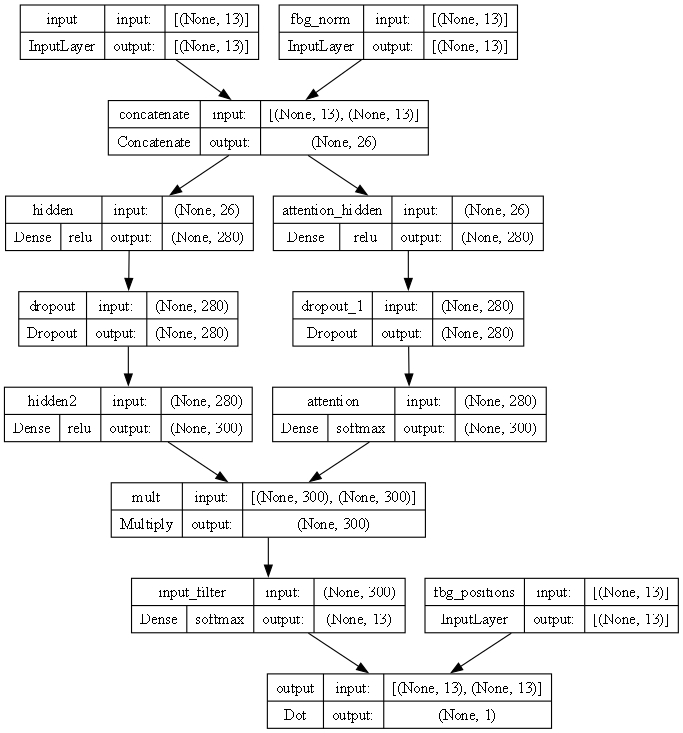

In [3]:
# Show the model architecture
keras.utils.plot_model(model, show_shapes=True, 
                       show_layer_names=True,show_layer_activations=True,
                       dpi=80)

# Model weights

Display model weights. Belo one can see the weight connecting each layer, the x-axis represent the input layer number and the y-axis the output layer.

In [4]:
# Helper function to plot the weights of the model
def plot_weights(model):
    """
    Function to plot the weights of a Keras neural network as heatmaps.
    
    Parameters:
    model (keras.Model): Keras model to visualize the weights.

    Returns:
    None
    """
    for layer_num, layer in enumerate(model.layers):
        weights_biases = layer.get_weights()
        if weights_biases:  # this check will verify if the layer has weights and biases
            weights, biases = [a.T for a in weights_biases]
            fig = plt.figure(figsize=(3.4, 2.5))
            sns.heatmap(weights, cmap='viridis')
            plt.title('Weights of ' + layer.name)
            plt.xlabel('Layer input')
            plt.ylabel('Layer output')
            plt.show()

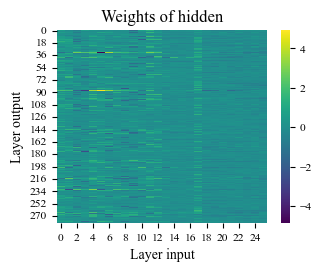

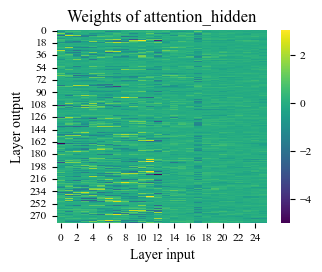

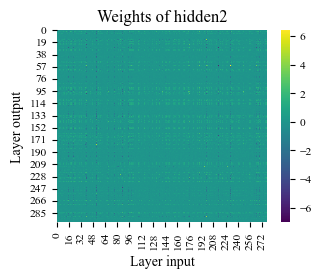

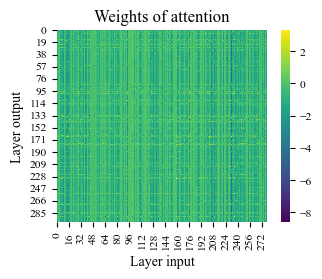

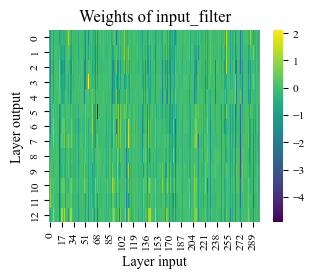

In [5]:
plot_weights(model)

# Layer output as function of LPFG parameters

Below we show what happends inside the model, i.e. each layer output for a given input. 

For better control, synthetic data was considered and only one LPFG parameter changed at time. And only LPFG spectra without noise was considered. On the next section the attention mechanism will be further explored and the impact of noisy LPFG analyzed.

Let us consider the following parameters: Resonant wavelength, the Resonant dip depth, and the Resonant dip width.


In [6]:
# Let us select the layers to be explored
intermediate_layers = ['hidden', 'hidden2', 'attention_hidden', 'attention', 'input_filter']
    

## Resonant wavelength

Let us analyse the impact of the resonant wavelength. Hence, one can see which neurons are activated by each spectral region of LPFG spectra.

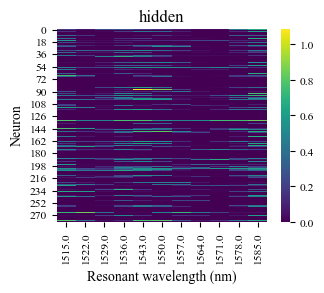

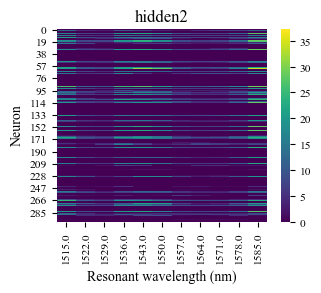

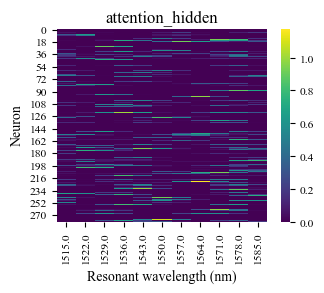

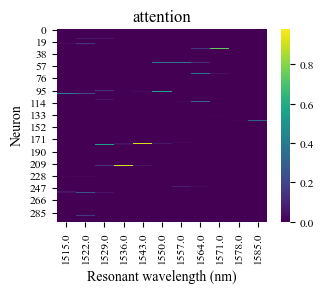

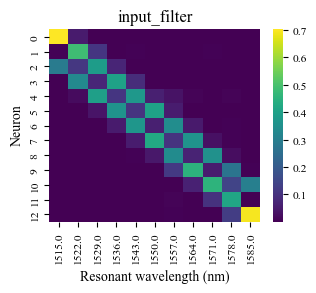

In [7]:
# Generate data for analysis - same LPFG parameter space as the training data
param = {'x':    [1510e-9, 1590e-9],  # base wavelength interval for FBGs
         'a':    [10, 40],            # depth
         'x0':   [],                  # resonant wavelength (to be populated)
         'w':    [15e-9, 40e-9],      # fwhm
         'bias': [0, 10],             # insertion loss
         'fcn':  [0, 1]}
# Set the number of samples for each resonant wavelength
N = 1000
k = 5
layers_output = {layer: [] for layer in intermediate_layers}
param_sweep = np.linspace(1515e-9, 1585e-9, 11)
for wl_res in param_sweep:
    # Generate  and preprocess the data
    param['x0'] = [wl_res, wl_res]
    subset = generate_synth_data(param, N, k, quiet=True)
    X, fbg_pos, fbg_norm, y = load_synth_data(subset)
    # Get the output of the layers of interest
    _, this_layers_out = get_layer_outputs(model, [X, fbg_pos, fbg_norm], intermediate_layers)
    # Store the mean behaviour of each layer for this resonant wavelength
    for i, layer in enumerate(intermediate_layers):    
        layers_output[layer].append(this_layers_out[i].mean(axis=0))

for layer in intermediate_layers:
        layers_output[layer] = pd.DataFrame(layers_output[layer], index=param_sweep*1e9)
        layers_output[layer].index = np.round(layers_output[layer].index, 1)
        plt.figure(figsize=(3.4, 2.5))
        plt.title(layer)
        sns.heatmap(layers_output[layer].T, cmap='viridis')
        plt.xlabel('Resonant wavelength (nm)')
        plt.ylabel('Neuron')
        plt.show()

## Coupling efficiency

Let us analyse the impact of coupling efficiency in the form of the resonant dip intensity.

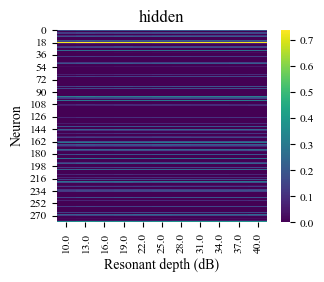

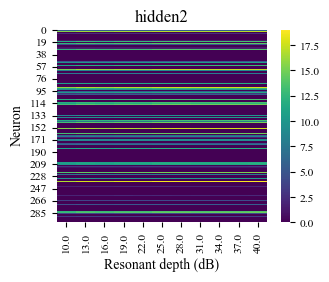

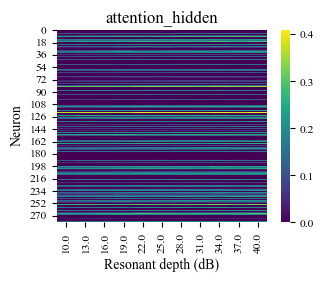

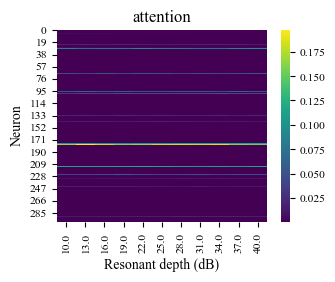

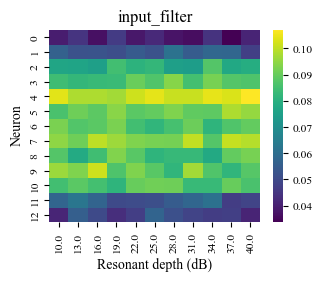

In [8]:
# Generate data for analysis - same LPFG parameter space as the training data
param = {'x':    [1510e-9, 1590e-9],  # base wavelength interval for FBGs
         'a':    [],                  # depth (to be populated)
         'x0':   [1515e-9, 1585e-9],  # resonant wavelength 
         'w':    [15e-9, 40e-9],      # fwhm
         'bias': [0, 10],             # insertion loss
         'fcn':  [0, 1]}
# Set the number of samples for each resonant wavelength
N = 1000
k = 5
layers_output = {layer: [] for layer in intermediate_layers}
param_sweep = np.linspace(10, 40, 11)
for a in param_sweep:
    # Generate  and preprocess the data
    param['a'] = [a, a]
    subset = generate_synth_data(param, N, k, quiet=True)
    X, fbg_pos, fbg_norm, y = load_synth_data(subset)
    # Get the output of the layers of interest
    _, this_layers_out = get_layer_outputs(model, [X, fbg_pos, fbg_norm], intermediate_layers)
    # Store the mean behaviour of each layer for this resonant wavelength
    for i, layer in enumerate(intermediate_layers):    
        layers_output[layer].append(this_layers_out[i].mean(axis=0))

for layer in intermediate_layers:
        layers_output[layer] = pd.DataFrame(layers_output[layer], index=param_sweep)
        layers_output[layer].index = np.round(layers_output[layer].index, 1)
        plt.figure(figsize=(3.4, 2.5))
        plt.title(layer)
        sns.heatmap(layers_output[layer].T, cmap='viridis')
        plt.xlabel('Resonant depth (dB)')
        plt.ylabel('Neuron')
        plt.show()

## FWHM

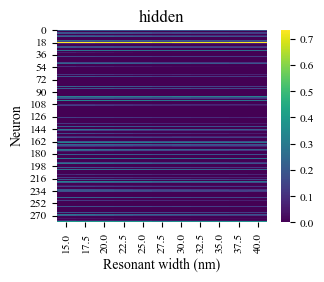

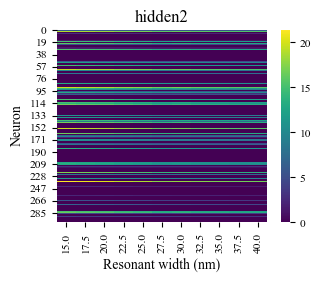

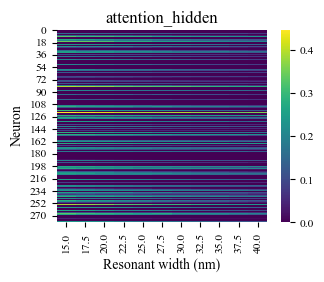

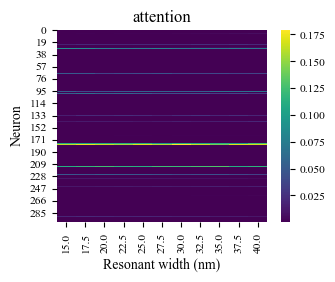

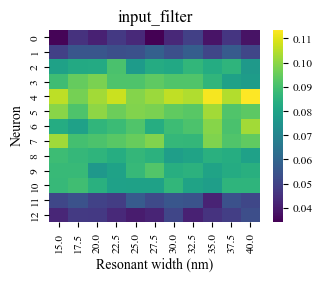

In [9]:
# Generate data for analysis - same LPFG parameter space as the training data
param = {'x':    [1510e-9, 1590e-9],  # base wavelength interval for FBGs
         'a':    [10, 40],            # depth
         'x0':   [1515e-9, 1585e-9],  # resonant wavelength 
         'w':    [],                  # fwhm (to be populated)
         'bias': [0, 10],             # insertion loss
         'fcn':  [0, 1]}
# Set the number of samples for each resonant wavelength
N = 1000
k = 5
layers_output = {layer: [] for layer in intermediate_layers}
param_sweep = np.linspace(15e-9, 40e-9, 11)
for fwhm in param_sweep:
    # Generate  and preprocess the data
    param['w'] = [fwhm, fwhm]
    subset = generate_synth_data(param, N, k, quiet=True)
    X, fbg_pos, fbg_norm, y = load_synth_data(subset)
    # Get the output of the layers of interest
    _, this_layers_out = get_layer_outputs(model, [X, fbg_pos, fbg_norm], intermediate_layers)
    # Store the mean behaviour of each layer for this resonant wavelength
    for i, layer in enumerate(intermediate_layers):    
        layers_output[layer].append(this_layers_out[i].mean(axis=0))

for layer in intermediate_layers:
        layers_output[layer] = pd.DataFrame(layers_output[layer], index=param_sweep*1e9)
        layers_output[layer].index = np.round(layers_output[layer].index, 1)
        plt.figure(figsize=(3.4, 2.5))
        plt.title(layer)
        sns.heatmap(layers_output[layer].T, cmap='viridis')
        plt.xlabel('Resonant width (nm)')
        plt.ylabel('Neuron')
        plt.show()

## Conclusions from neuron activation

Considering the results obtained varying several LPFG parameters and observing the activation of each neuron of the network, one could note that the neuron activation is highly sensitive to the LPFG resonant wavelength. Hence, the weights encode the resonant wavelength, with a singular neuron combination for each spectral region.

For the dip depth and width, there was no clear correlation with the neuron activation. These results showed the model effectively focus on the resonant wavelength information because the mean neurons’ behavior was only regarding the resonant wavelength.


# Exploring attention

Below we explore the attention mechanism, showing how the system behaves given two different LPFGs.

In [12]:
# Function to compare the inputs, hidden layers and attention layer
def compare2inputs(model, x, fbg_pos, input_names=None):
    """
    This function compares the outputs of two inputs on a given model.
    It visualizes the outputs of the 'hidden', 'attention', and 'hidden2' layers of the model.

    Parameters:
    model: The model to be used for comparison.
    x: The first input to the model.
    fbg: The second input to the model.
    input_names: The names of the inputs. Defaults to ['A', 'B'].

    Raises:
    ValueError: If more than two inputs are entered.
    """

    # Check if only two inputs are entered
    if x.shape[0] != 2 or fbg_pos.shape[0] != 2:
        raise ValueError('Only two inputs should be entered!')

    # Set default input names if not provided
    if input_names is None:
        input_names = ['A', 'B']

    fbg_norm = (fbg_pos - 1500)/(1600-1500)

    # Get the output and the intermediate layers' outputs of the model for the two inputs
    out, intermediate_layers = get_layer_outputs(model, [x, fbg_pos, fbg_norm], ['hidden', 'attention', 'hidden2', 'input_filter'])

    # Extract the outputs of the 'hidden', 'attention', and 'hidden2' layers
    hidden, att, hiden2, filtered = intermediate_layers

    # Create a figure for the subplots
    size = (2*3.4, 2.5)
    
    fig = plt.figure(figsize=size)

    # Define the subplots
    ax0 = fig.add_subplot(2, 4, 1)  # First row, first column
    ax1 = fig.add_subplot(2, 4, 5)  # Second row, first column
    ax2 = fig.add_subplot(1, 4, 2)  # Both rows, second column

    # List of axes for easy access
    ax = [ax0, ax1, ax2]#, ax3]#, ax4]

    # Plot heatmaps of the inputs and the 'hidden' layer outputs
    sns.heatmap(x, cmap='rocket_r', vmin=0, vmax=1, square=False, cbar=True, ax=ax[0], cbar_kws={'label': 'Input strength'})
    sns.heatmap(fbg_norm, cmap='rocket_r', vmin=0, vmax=1, square=False, cbar=True, ax=ax[1], cbar_kws={'label': 'FBG position'})
    sns.heatmap(hiden2, cmap='YlOrBr', vmin=0, vmax=1, square=False, cbar=False, ax=ax[2], cbar_kws={'label': 'Neuron out.'})
    # Plot the 'attention' layer output
    ax[2].plot(0.5-att[0, :], '-b', lw=3, alpha=0.7, label='Attention map')
    ax[2].plot(1.5-att[1, :], '-b', lw=3, alpha=0.7, label=None)
    ax[2].legend(fontsize=6)
    
    # Plot heatmap of the 'hidden2' layer output
    #sns.heatmap(filtered, cmap='vlag', vmin=-1, vmax=1, square=False, cbar=False, ax=ax[3], cbar_kws={'label': 'Neuron out.'})

    #sns.heatmap(filtered, cmap='rocket_r', vmin=0, vmax=1, square=False, cbar=False, ax=ax[4], cbar_kws={'label': 'Filter out.'})

    ax[0].set_title('Input', fontsize=7.5)
    ax[2].set_title('Hidden features', fontsize=7.5)
    
    # Remove x-axis labels for the first subplot
    ax[0].set_xticklabels([])

    # Set y-axis labels for all subplots
    for axi in ax:
        axi.set_yticklabels(input_names)

    # Set x-axis label for the last 3 subplots
    for axi in ax[1::]:
        axi.set_xlabel('Neuron')

    # Adjust colorbar label size for the first two subplots
    cbar = ax[0].collections[0].colorbar
    cbar.ax.yaxis.label.set_size(7)
    cbar = ax[1].collections[0].colorbar
    cbar.ax.yaxis.label.set_size(7)

    # Adjust layout and display the plot
    plt.tight_layout()
    return fig


## LPFG position effect

Here we show how the outputs change given a LPFG shift. It is the same analysis as presented in the *Layer outputs by resonant wavelength* section, but with a synthetic spectrum, static FBG array and input demonstration, for better visualization.

1540: 1530.22 +- 0.12
1560: 1560.01 +- 0.07


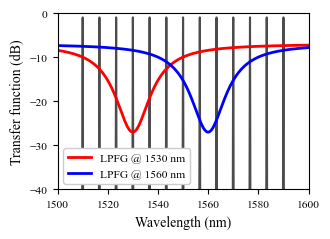

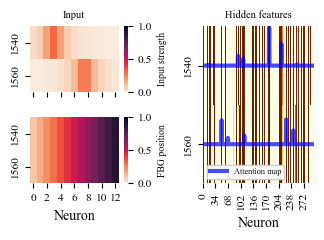

In [16]:
# Let us assume the FBG interrogator source is constant in 0 dBm
optical_source = np.array([wl, np.zeros_like(wl)]).T
# Set the FBG positions in nm
fbg_pos = np.array([1510, 1516, 1523, 1530, 1537, 1543, 1550, 1556, 1563, 1570, 1577, 1583, 1590])

# Generate example
# Wavelength for simulation
wl = np.linspace(1450, 1650, 10000)
# LPFG parameters
coupling_strength = 20 # dB, the resonant dip depth
fwhm = 30e-9 # m, the full width at half maximum of the resonant dip
insertion_loss = 4 # dB, the insertion loss of the LPFG
function_number = 0.1 # to select a loretzian function

wl_res_examples = [1530, 1560]
# Create an LPFG transmission function at 1540
dip_depth, resonant_wl, dip_width, insertion_loss =  20, wl_res_examples[0], 40, 7
_, transfer_a = noisy_arbitrary_funcs(wl*1e-9, dip_depth, resonant_wl*1e-9, dip_width*1e-9, insertion_loss, function_number)

# Create an LPFG transmission function at 1560
dip_depth, resonant_wl, dip_width, insertion_loss =  20, wl_res_examples[1], 40, 7
_, transfer_b = noisy_arbitrary_funcs(wl*1e-9, dip_depth, resonant_wl*1e-9, dip_width*1e-9, insertion_loss, function_number)

plt.figure(figsize=(3.4, 2.5))
fbg_pos = np.linspace(1510, 1590, 13)
for fbg in fbg_pos:
    wl_sim = np.linspace(fbg-1, fbg+1, 1000)
    fbg_r = fbg_reflection(fbg*1e-9, 100e-12, wl_sim*1e-9) - 1
    plt.plot(wl_sim, fbg_r, 'k', alpha=0.7)
plt.plot(wl, transfer_a, 'r', lw=2, label=f'LPFG @ {wl_res_examples[0]} nm')
plt.plot(wl, transfer_b, 'b', lw=2, label=f'LPFG @ {wl_res_examples[1]} nm')
plt.xlim(1500, 1600)
plt.ylim(-40, 0)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transfer function (dB)')
plt.legend(loc='lower left', framealpha=1)
plt.tight_layout()

f_model = K.function(model.input,
                     model.output)
                     
x_a, fbg, fbg_norm = get_lpfg_inputs(wl, transfer_a, fbg_pos, optical_source)
y_a, u_a = predict_with_uncertainty(f_model, [x_a.reshape(1,-1), fbg.reshape(1,-1), fbg_norm.reshape(1,-1)], n_iter=10)


x_b, fbg, fbg_norm  = get_lpfg_inputs(wl, transfer_b, fbg_pos, optical_source)
y_b, u_b = predict_with_uncertainty(f_model, [x_b.reshape(1,-1), fbg.reshape(1,-1), fbg_norm.reshape(1,-1)], n_iter=10)

print(f'1540: {y_a[0]:.2f} +- {u_a[0]:.2f}')
print(f'1560: {y_b[0]:.2f} +- {u_b[0]:.2f}')

x = np.array([x_a, x_b])
fbg = np.array([fbg, fbg])

fig = compare2inputs(model, x, fbg, input_names=['1540', '1560'])

plt.show()

## Ideal vs distorted LPFG

Below we create a LPFG transmission function with a single distinct resonant dip and another one with some distortions and a second dip outside the interrogator range.

This might be the most influential part of attention!

Ideal: 1549.86 +- 0.09
Distorted: 1549.91 +- 0.19


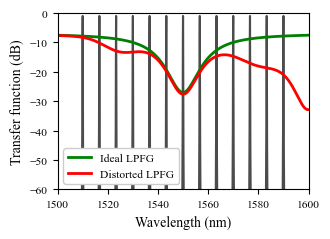

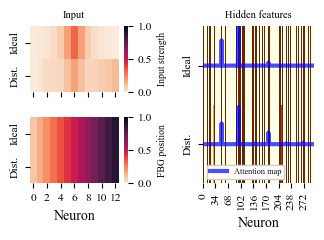

In [17]:
# Generate example
# Create an ideal synthetic LPFG transmission function
dip_depth, resonant_wl, dip_width, insertion_loss =  20, 1550, 40, 7
_, transfer = noisy_arbitrary_funcs(wl*1e-9, dip_depth, resonant_wl*1e-9, dip_width*1e-9, insertion_loss, function_number)

plt.figure(figsize=(3.4, 2.5))
fbg_pos = np.linspace(1510, 1590, 13)
for fbg in fbg_pos:
    wl_sim = np.linspace(fbg-1, fbg+1, 1000)
    fbg_r = fbg_reflection(fbg*1e-9, 100e-12, wl_sim*1e-9) - 1
    plt.plot(wl_sim, fbg_r, 'k', alpha=0.7)
plt.plot(wl, transfer, 'g', lw=2, label='Ideal LPFG')
plt.xlim(1500, 1600)
plt.ylim(-60, 0)

# Create an LPFG with some distortions
_, secondary_dip = noisy_arbitrary_funcs(wl*1e-9, dip_depth+5, 1600e-9, (dip_width+5)*1e-9, insertion_loss, function_number)
transfer_2 = copy(transfer) + secondary_dip
transfer_2 += my_gauss(wl, 4, 1525, 10, 0)
transfer_2 += my_gauss(wl, 6, 1580, 20, 0)
il_dif = max(transfer) - max(transfer_2)
transfer_2 += il_dif
plt.plot(wl, transfer_2, 'r', lw=2, label='Distorted LPFG')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transfer function (dB)')
plt.legend(loc='lower left', framealpha=1)
plt.tight_layout()


x_ideal, fbg, fbg_norm = get_lpfg_inputs(wl, transfer, fbg_pos, optical_source)
y_ideal, u_ideal = predict_with_uncertainty(f_model, [x_ideal.reshape(1,-1), fbg.reshape(1,-1), fbg_norm.reshape(1,-1)], n_iter=10)

x_dist, fbg, fbg_norm = get_lpfg_inputs(wl, transfer_2, fbg_pos, optical_source)
y_dist, u_dist = predict_with_uncertainty(f_model, [x_dist.reshape(1,-1), fbg.reshape(1,-1), fbg_norm.reshape(1,-1)], n_iter=10)

print(f'Ideal: {y_ideal[0]:.2f} +- {u_ideal[0]:.2f}')
print(f'Distorted: {y_dist[0]:.2f} +- {u_dist[0]:.2f}')

x = np.array([x_ideal, x_dist])
fbg = np.array([fbg, fbg])

fig = compare2inputs(model, x, fbg, input_names=['Ideal', 'Dist.'])

plt.show()


## Designed FBG array vs shifted FBG array

We explored the effect of FBG shift, by considering the FBGs at the designed Bragg wavelength and at arbitraty shifted positions.

One can see a great difference at the input layer, but a verry good estimation for both. The attention and second hidden effects are similar to the shown before.

Ideal: 1549.88 +- 0.06
Distorted: 1549.78 +- 0.25


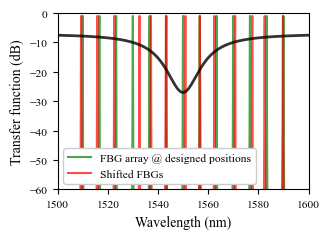

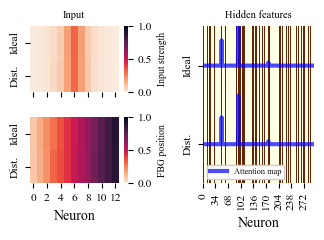

In [18]:
# Generate example
# Create a synthetic LPFG transmission function
dip_depth, resonant_wl, dip_width, insertion_loss =  20, 1550, 40, 7
_, transfer = noisy_arbitrary_funcs(wl*1e-9, dip_depth, resonant_wl*1e-9, dip_width*1e-9, insertion_loss, function_number)

plt.figure(figsize=(3.4, 2.5))
# The designed positions
fbg_pos = np.linspace(1510, 1590, 13)
# The shifted positions
shifted_fbg = fbg_pos + np.random.normal(0, 1, fbg_pos.shape)   

# Plot designed array
lb = 'FBG array @ designed positions'
for fbg in fbg_pos:
    wl_sim = np.linspace(fbg-1, fbg+1, 1000)
    fbg_r = fbg_reflection(fbg*1e-9, 100e-12, wl_sim*1e-9) - 1
    plt.plot(wl_sim, fbg_r, 'g', alpha=0.7, label=lb)
    lb = None
# Plot shifted array
lb = 'Shifted FBGs'
for fbg in shifted_fbg:
    wl_sim = np.linspace(fbg-1, fbg+1, 1000)
    fbg_r = fbg_reflection(fbg*1e-9, 100e-12, wl_sim*1e-9) - 1
    plt.plot(wl_sim, fbg_r, 'r', alpha=0.7, label=lb)
    lb = None


plt.plot(wl, transfer, 'k', alpha=0.8, lw=2, label=None)
plt.xlim(1500, 1600)
plt.ylim(-60, 0)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transfer function (dB)')
plt.legend(loc='lower left', framealpha=1)
plt.tight_layout()


x_ideal, fbg_ideal, fbg_ideal_norm = get_lpfg_inputs(wl, transfer, fbg_pos, optical_source)
y_ideal, u_ideal = predict_with_uncertainty(f_model, [x_ideal.reshape(1,-1), fbg_ideal.reshape(1,-1), fbg_ideal_norm.reshape(1,-1)], n_iter=10)

x_shift, fbg_shift, fbg_shift_norm = get_lpfg_inputs(wl, transfer, shifted_fbg, optical_source)
y_shift, u_shift = predict_with_uncertainty(f_model, [x_dist.reshape(1,-1), fbg_shift.reshape(1,-1), fbg_shift_norm.reshape(1,-1)], n_iter=10)

print(f'Ideal: {y_ideal[0]:.2f} +- {u_ideal[0]:.2f}')
print(f'Distorted: {y_shift[0]:.2f} +- {u_shift[0]:.2f}')

x = np.array([x_ideal, x_shift])
fbg = np.array([fbg_ideal, fbg_shift])

fig = compare2inputs(model, x, fbg, input_names=['Ideal', 'Dist.'])

plt.show()
